# What is this notebook about?

Here we learn how to build images for timeseries using SIMuRG data (see `sample_series.png` if image below is not displayed). For GNSS studies it is convinient to show data from several receivers stacked. This kind of visualization allow estimate the ionospheric effect offset at different stations. By choosing same satellite we minimize the effect of GNSS sounding geometry.

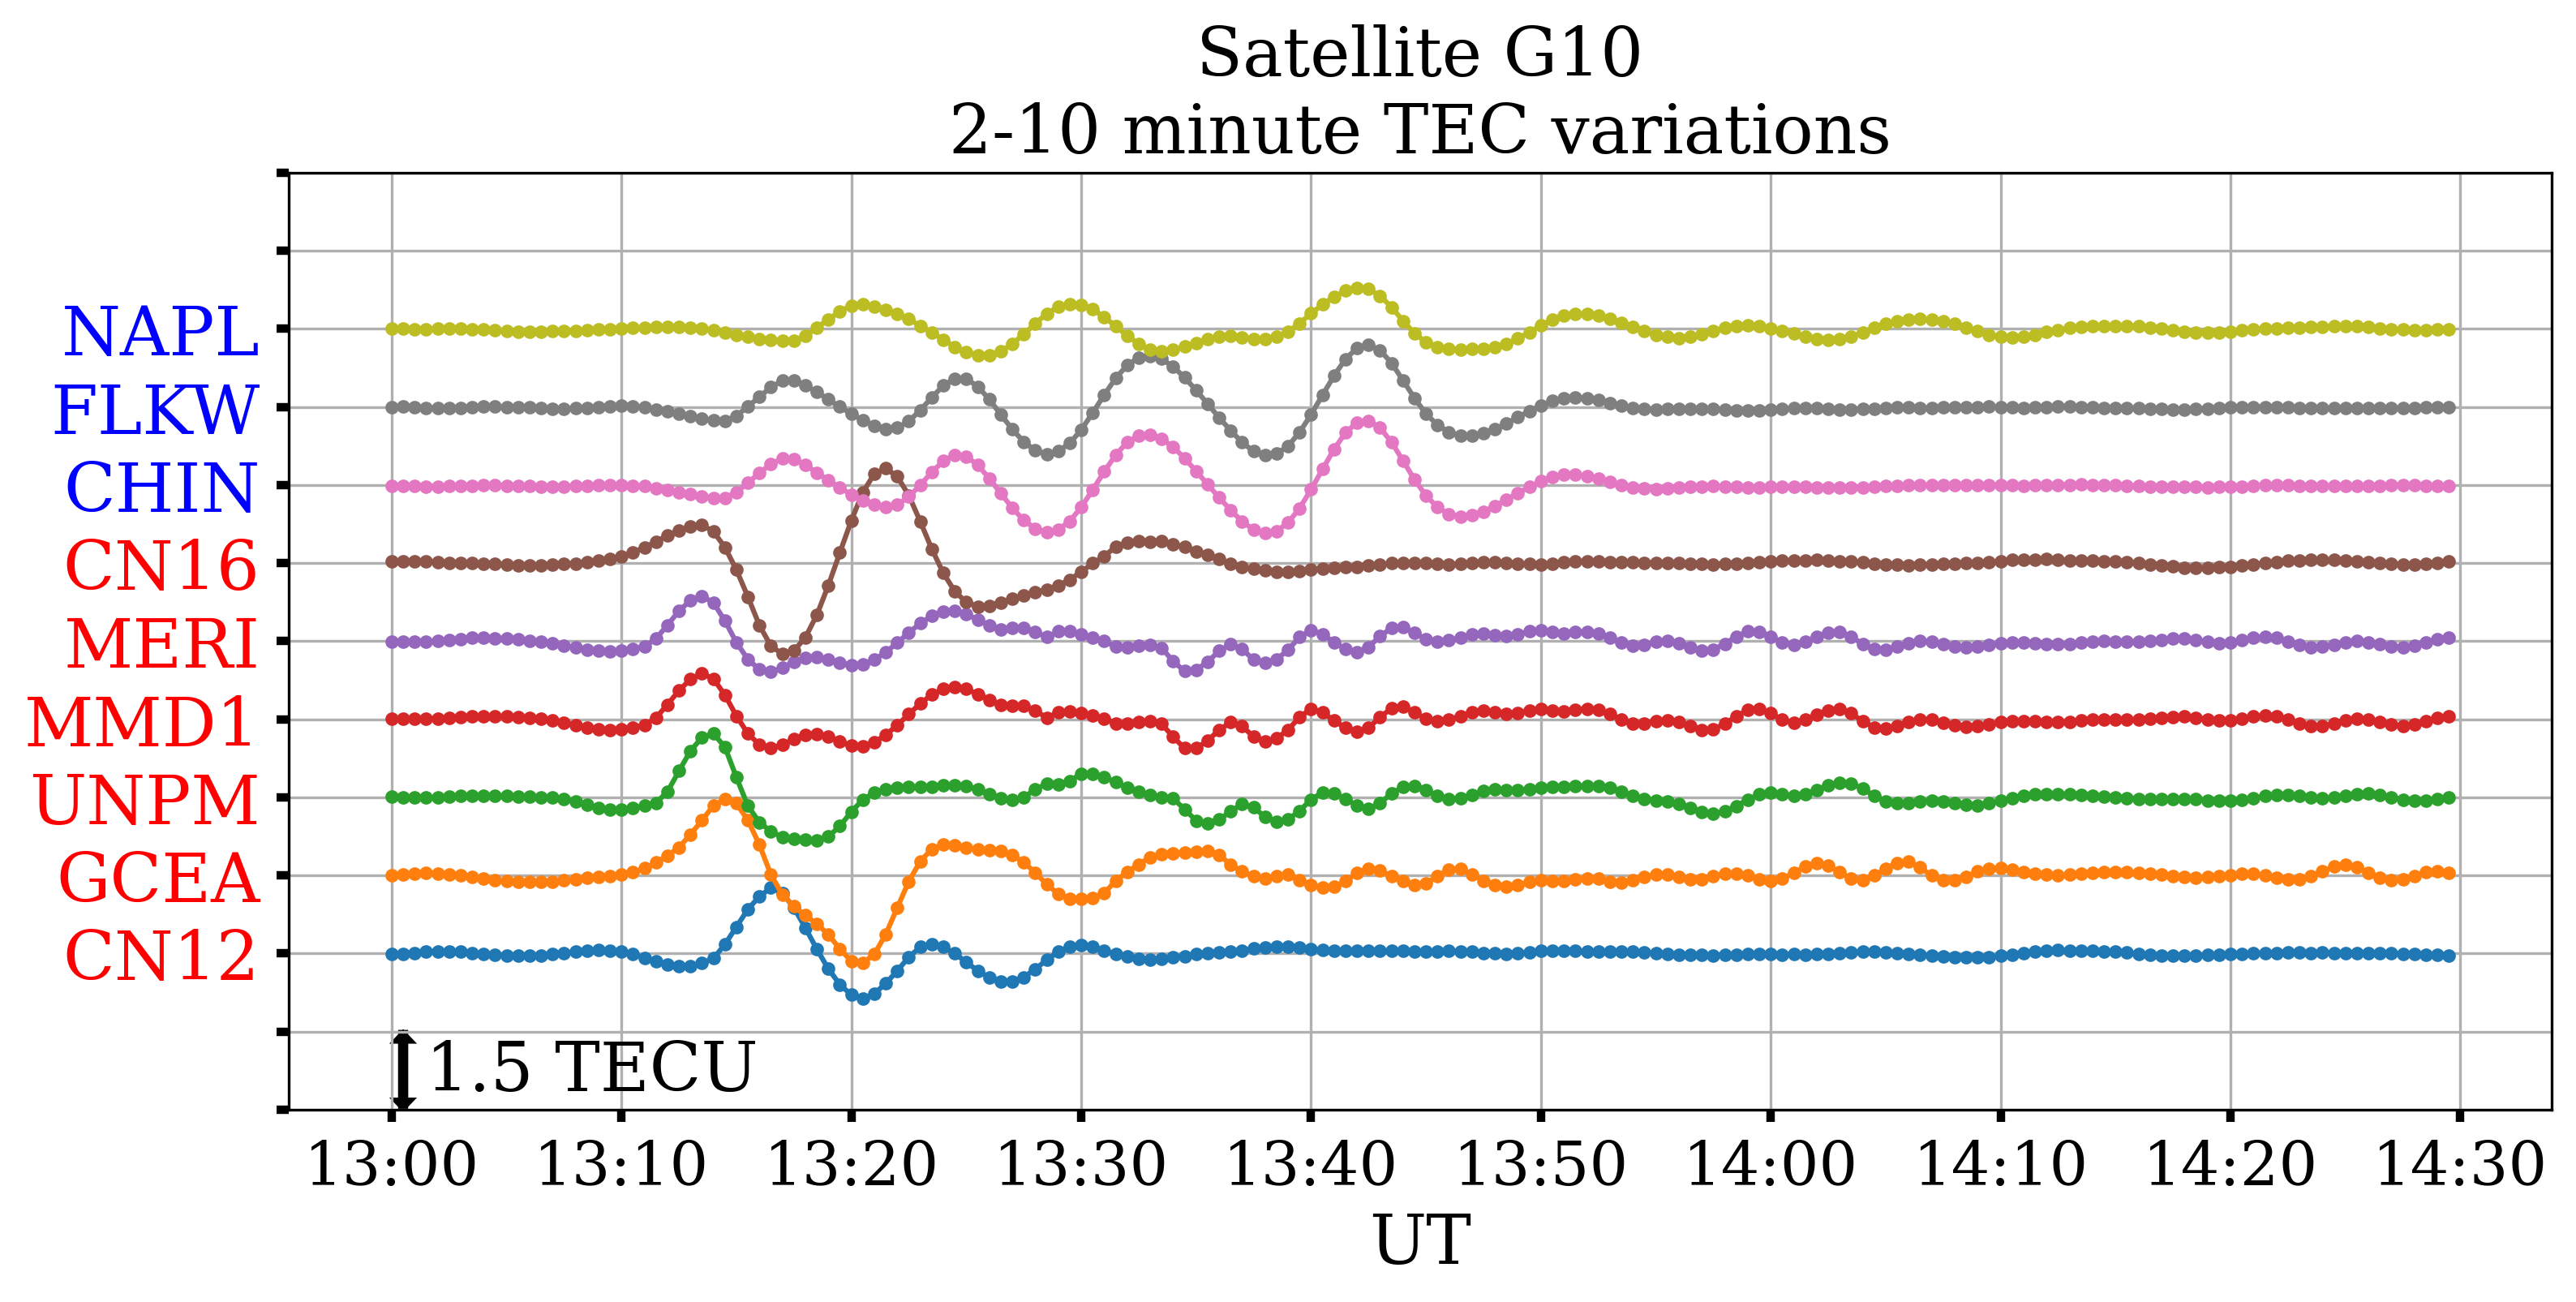

> NOTE: GNSS data are distributed as RINEX files and SIMuRG collects and process them to produce single HDF-formatted file. Use of SIMuRG removes need to make processing by hands.

 

# Rules of conduct

The code of this note book is distribute under MIT licence. Feel free to use it for your research. If you want to contribute open issue on GitHub plan your work and then commit changes and make pull request.

### Cite proper paper if appropriate

This notebook could serve many goals and uses data from SIMuRG. You will greatly help if use one of publication SIMuRG team makes if it suits your research:

* For general SIMuRG use: **Yasyukevich, Y.V., Kiselev, A.V., Zhivetiev, I.V. et al. SIMuRG: System for Ionosphere Monitoring and Research from GNSS. GPS Solut 24, 69 (2020)**   
* For GNSS-TEC filtation: **Maletckii, B., Yasyukevich, Y., & Vesnin, A. (2020). Wave signatures in total electron content variations: Filtering problems. Remote Sensing, 12(8), 1340.**
* For global ionospheric content: **Afraimovich, E. L., Astafyeva, E. I., Oinats, A. V., Yasukevich, Y. V., & Zhivetiev, I. V. (2008, February). Global electron content: A new conception to track solar activity. In Annales Geophysicae (Vol. 26, No. 2, pp. 335-344). Copernicus GmbH.**
* For GNSS-ionospheric study Earthquakes: **Vesnin, A., Yasyukevich, Y., Perevalova, N., & Şentürk, E. (2023). Ionospheric Response to the 6 February 2023 Turkey–Syria Earthquake. Remote Sensing, 15(9), 2336.**
* For GNSS-ionospheric study of spacecraft launches: **Yasyukevich, Y. V., Vesnin, A. M., Astafyeva, E., Maletckii, B. M., Lebedev, V. P., & Padokhin, A. M. (2024). Supersonic waves generated by the 18 November 2023 Starship flight and explosions: Unexpected northward propagation and a man‐made non‐chemical depletion. Geophysical Research Letters, 51(16), e2024GL109284.**
* For GNSS-ionospheric study of geomagnetic storms: **Danilchuk, E., Yasyukevich, Y., Vesnin, A., Klyusilov, A., & Zhang, B. (2025). Impact of the May 2024 Extreme Geomagnetic Storm on the Ionosphere and GNSS Positioning. Remote Sensing, 17(9), 1492.**


### Data availabilty 

Data of global GNSS network are available at https://simurg.space, 

# Brief recall of GNSS method

There is several ways to look at GNSS data in terms of ionospheric studies. In current notebook we will use time series representation of GNSS data. For time series we only interesting in satellite-site pairs and times. Elevation, azimuth, as well as latitude and longitude of SIPs are not relevant for visualizations. 

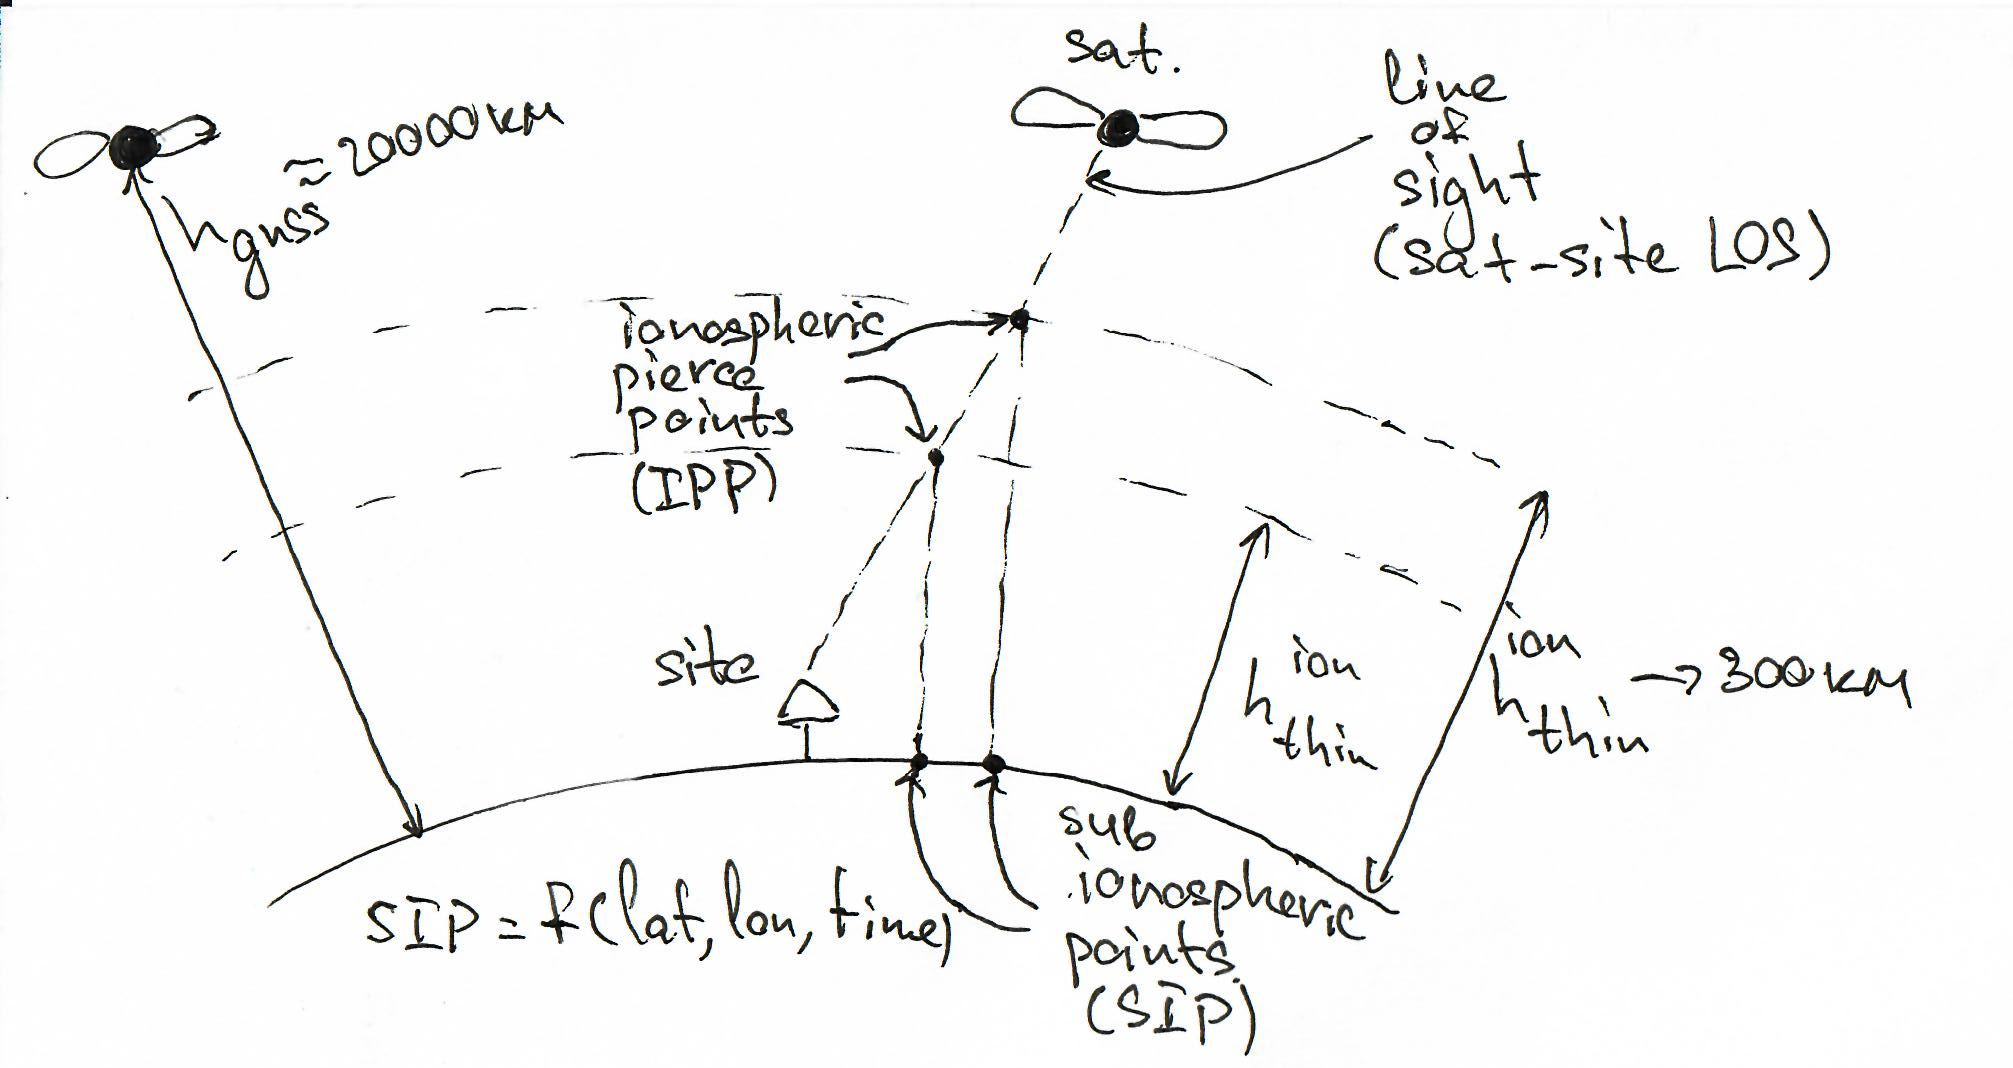

# How to start using this notebook

[Load and install](https://docs.conda.io/projects/conda/en/stable/) anaconda to make sure we on the same page. You can use **miniconda** to make download more lightweight. If link above is not working 

https://docs.conda.io/en/latest/

If you are on Windows open **Anaconda propmt**. On linux Anaconda should be available in terminal. Execute commands:

```bash
conda deactivate # to make sure we not interfere with other environments
conda create -n simurg_cases python=3.10  # create environment with proper python version
conda activate simurg_cases  # activate environment - the following commands will work in itz
conda install jupyterlab  # installing execution environment for the Notebook
conda install cartopy  # installing cartopy which recently a 
jupyter-lab  # launch execution environment for the Notebook
```

After jupyter lab is launched you will get execution enviroment for the notebook. Just click the 

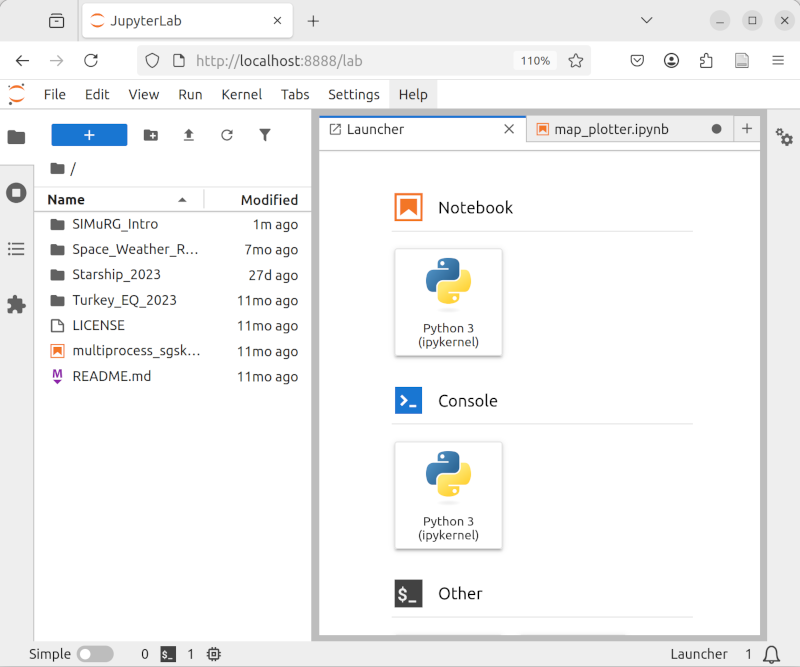

You can download this notebook and place it in the folder (or subfolder) from which you have launched `jupyter-lab`

(Optionally) To obtain all notebooks use git.

```bash
git clone https://github.com/gnss-lab/studies.git
# git checkout branch-name 
cd ./studies
```

Or download them manually from `https://github.com/gnss-lab/studies`


# Install dependecies

Each notebook uses it set of python library. We keep them in separate cell to install from notebook itself. Jupyter kernel restart might be required. If you got `Module not found error`  anywhere in current notebook you can include this dependency below as separate line `!pip install module_that_was_not_found`

In [ ]:
!pip install numpy
!pip install matplotlib
!pip install requests
!pip install h5py

# Load data from simurg 

> **NOTE: SIMuRG is query based. If you need particular data go to `https://simurg.space/create_map` and select proper region and time range. Other parameters could be remains by default. After query is done you can proceed to futher processing**

Data that contain series could be access via links like `https://simurg.space/gen_file?data=obs&date=2025-01-01` 

> **Note: You can check link is correct in advance by opening it in browser**

Lets define several structures to keep data in groups. We call separate kind of data as **data product**. So ROTI and TEC are different dataproducts. To deal with different data products you can extend members of `DataProducts` with that products. 

In [55]:
from dataclasses import dataclass
from enum import Enum
from pathlib import Path

@dataclass
class ColorLimits():
    min: float
    max: float
    units: str

@dataclass(frozen=True)
class DataProduct(): 
    long_name: str
    hdf_name: str
    color_limits: ColorLimits

@dataclass
class SimurgDataFile():
    url: str
    local_path: Path


### Function for data download 

Futher develop function for data download. Variable `override` defines whther data should be downloaded in anyway or only when they not available locally. Function introduces progress bar via `response.iter_content()` and `sys.stdout.write()`, `sys.stdout.flush()`. The progress bar looks like:

```bash
Downloading 2025-01-05.h5 from https://simurg.space/gen_file?data=obs&date=2025-01-05
[===========================                        ]
```

In [56]:
import requests
import os
import sys
from pathlib import Path
import logging

logging.getLogger("requests").setLevel(logging.WARNING)
logging.getLogger("urllib3").setLevel(logging.WARNING)

def load_data(
    url: str, 
    local_file: Path,
    override: bool = False
) -> None:
    if local_file.exists() and not override:
        print(f"File {local_file} exists. Use override=True to download it again.")
        return 
        
    with open(local_file, "wb") as f:
        print(f"Downloading {local_file} from {url}")
        response = requests.get(url, stream=True)
        total_length = response.headers.get('content-length')

        if total_length is None: 
            f.write(response.content)
        else:
            dl = 0
            previous = 0
            total_length = int(total_length)
            for chunk in response.iter_content(chunk_size=4096):
                dl += len(chunk)
                f.write(chunk)
                done = int(50 * dl / total_length)
                if done > previous: # to prevent warnings from notebook
                    sys.stdout.write("\r[%s%s]" % ('=' * done, ' ' * (50-done)) )    
                    sys.stdout.flush()
                previous = done
            sys.stdout.write("\n")

### Data download

Now we are ready to call `load_data()`.

> **To work with your data change link `simurg.space/gen_file?data=obs&date=2025-01-05.h5` to proper one.**

> Make sure you have `override=True` or different `Path("roti.h5")` if change url.

In [57]:
from datetime import datetime
from dateutil import tz

_UTC = tz.gettz('UTC')
study_date = datetime(2025, 1, 5).replace(tzinfo=_UTC)
filename = study_date.strftime("%Y-%m-%d.h5")

series_files = {
    study_date: SimurgDataFile(
        f"https://simurg.space/gen_file?data=obs&date={filename[:-3]}", # on simurg.space extension '.h5' is not used
        Path(filename),
    ),
}
for date, data_file in series_files.items():
    load_data(data_file.url, data_file.local_path, override=True)

[==================================================]


## Data structure

Now lets look at file and see how to select satellites that we observe over the region:

```
HDF_FILE
    -> site1 (attributes: lat, lon)
    -> site2 (attributes: lat, lon)
    -> site3 (attributes: lat, lon)
        -> sat1
            -> timestamp
            -> azimuth 
            -> dtec_10_20
            -> dtec_20_60
            -> dtec_2_10
            -> elevation
            -> roti
            -> tec
            -> tec_adjusted
        -> sat2
            -> data
        ...
    ...
    -> siteN (attributes: lat, lon)
```

We see how data are grouped. **Site** groups go first, **satellites** is the next level, and finally we go to the **data products**. Site group also has **attributes** that store information relevant to Site - for example coordinates.

## Lets define dataclasses to keep info for our data products

In [58]:
class DataProducts(Enum):
    roti = DataProduct("ROTI", "roti", ColorLimits(-0, 0.5, 'TECU/min'))
    dtec_2_10 = DataProduct("2-10 minute TEC variations", "dtec_2_10", ColorLimits(-0.4, 0.4, 'TECU'))
    dtec_10_20 = DataProduct("10-20 minute TEC variations", "dtec_10_20", ColorLimits(-0.6, 0.6, 'TECU'))
    dtec_20_60 = DataProduct("20-60 minute TEC variations", "dtec_20_60", ColorLimits(-0.8, 0.8, 'TECU'))
    atec = DataProduct("Vertical TEC adjusted using GIM", "tec_adjusted", ColorLimits(0, 50, 'TECU'))
    elevation = DataProduct("Elevation angle", "elevation", ColorLimits(0, 90, 'Degrees'))
    azimuth = DataProduct("Azimuth angle", "azimuth", ColorLimits(0, 360, 'Degrees'))
    timestamp = DataProduct("Timestamp", "timestamp", None)
    time = DataProduct("Time", None, None)

# Develop function for data retrieval

To keep memory usage as low as possible we will load data for particular sites. So the first step is to retrieve sites for particular region. Since site coordinates are in the HDF-file we could easily acces them via `h5py`.

To be able to male type annotation as `list[GnssSite]` we implement two helpful dataclasses `GnssSite` and `GnssSat`. To make sure that sites are compared and used as `dict` keys correctly we implement `__hash__()` and `__eq__()` manually to use only `name`. 

```python
def __hash__(self):
    return hash(self.name)

def __eq__(self, other):
    if not isinstance(other, GnssSat):
        return NotImplemented
    return self.name == other.name
```


In [182]:
import h5py 
import numpy as np
from dataclasses import dataclass
from numpy.typing import NDArray

@dataclass(frozen=True)
class GnssSite:
    name: str
    lat: float
    lon: float

    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        if not isinstance(other, GnssSat):
            return NotImplemented
        return self.name == other.name

@dataclass
class GnssSat:
    name: str
    system: str
    
    def __hash__(self):
        return hash(self.name)

    def __eq__(self, other):
        if not isinstance(other, GnssSat):
            return NotImplemented
        return self.name == other.name

def get_sites(
    local_file: str | Path,
    min_lat: float = -90, 
    max_lat: float = 90,
    min_lon: float = -180, 
    max_lon: float = 180
) -> list[GnssSite]:    
    """Reads hdf file for site information.
    
    Coordinates are stored in site group attributes: f["SITE"].attrs.
    Coordinates are given in radians and should be converted to degree if 
    needed. Output will contain only site in region defined by min_lat, 
    max_lat, min_lon, max_lon. 
    """
    f = h5py.File(local_file)
    sites_names = list(f.keys())
    sites = list()
    for site_name in sites_names:
        site_info = f[site_name].attrs
        site_lat = np.degrees(site_info['lat'])
        site_lon = np.degrees(site_info['lon'])
        if min_lat < site_lat < max_lat and min_lon < site_lon < max_lon:
            sites.append(GnssSite(site_name, site_lat, site_lon))
    f.close()
    return sites


In [183]:
sites = get_sites(
    series_files[study_date].local_path,     
    min_lat = 30, 
    max_lat = 50,
    min_lon = -120, 
    max_lon = -90
)
print(sites[:3])

[GnssSite(name='dhlg', lat=33.38980219827626, lon=-115.78801552747264), GnssSite(name='drao', lat=49.322619657434224, lon=-119.62498082974702), GnssSite(name='gol2', lat=35.42515207162728, lon=-116.88923700215045)]


# Develop function for data retrieval.

Given sites we can retrieve data for them. See hdf-file structure to see how this code works

In [199]:
def retrieve_visible_sats_data(
    local_file: str | Path,
    sites: list[GnssSite],
) -> dict[GnssSite, dict[GnssSat, dict[DataProduct, NDArray]]]:
    """Select data for given epoch and sites.
    
    Return dict with numpy arrays that contain data for given satellite.
    We addres data related to particular site and satellite as 
    result[SITE][SAT]. For example ROTI data for IRKJ site and G21 satellites
    will be retrieved from result as result["irkj"]["G21"]["roti"]
    """
    f = h5py.File(local_file)
    data = dict()
    for site in sites:
        if not site.name in f: 
            continue
        data[site] = dict()
        sats = f[site.name].keys()
        for sat_name in sats:
            sat = GnssSat(sat_name, sat_name[0])
            timestamps = f[site.name][sat.name][DataProducts.timestamp.value.hdf_name][:]
            times = [datetime.fromtimestamp(t).replace(tzinfo= _UTC) for t in timestamps]
            # time is not in HDF so we add it separate from loop over other data products    
            data[site][sat] = {DataProducts.time.value: np.array(times)}
            for data_product in DataProducts:
                if data_product.value.hdf_name is None:
                    continue
                data[site][sat][data_product] = f[site.name][sat.name][data_product.value.hdf_name][:]
    f.close()
    return data

In [200]:
from collections import defaultdict

def reoder_data_by_sat(
    data: dict[GnssSite, dict[GnssSat, dict[DataProduct, NDArray]]], 
) -> dict[GnssSat, dict[GnssSite, dict[DataProduct, NDArray]]]:
    """ Reoders the date to get satellite first."""
    _data = defaultdict(dict)
    for site in data:
        for sat in data[site]:
            # note reverse keys order
            _data[sat][site] = data[site][sat] 
    return _data

# Retrieve data products

Now we are ready to retrieve data from HDF file.

In [201]:
series_by_site = retrieve_visible_sats_data(series_files[study_date].local_path, sites)
series_by_sat = reoder_data_by_sat(series_by_site)

# Develop function for plots

First define parameters and use class for point event. While latitude and longitude are irrelevant for the current series plots, however same class could be used in different notebooks (for example for map plots). 

In [242]:
from typing import Any
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.dates as mdates

DEFAULT_PARAMS = {
    'font.size': 20,
    'figure.dpi': 300,
    'font.family': 'serif',
    #'font.family': 'monospace',
    'font.style': 'normal',
    'font.weight': 'light',
    'legend.frameon': True,
    'font.variant' : 'small-caps',
    'axes.titlesize' : 20,
    'axes.labelsize' : 20,
    'xtick.labelsize' : 18,                         
    'xtick.major.pad': 5,
    'ytick.major.pad': 5,   
    'xtick.major.width' : 2.5,
    'ytick.major.width' : 2.5,
    'xtick.minor.width' : 2.5,
    'ytick.minor.width' : 2.5,
    'ytick.labelsize' : 20,
}

@dataclass
class PointEvent:
    lat: float
    lon: float
    time: datetime

def plot_single_sat(
    data_plot: dict[GnssSat, dict[GnssSite, dict[DataProduct, list | NDArray]]], 
    sat: str,
    plot_product: DataProduct, 
    event: datetime,
    title: str = "",
    limits: tuple = (3600,3600),
    shift: float = 0.5,
    site_labels: bool = False,
    figsize: tuple = None,
    label_colors: dict[GnssSite, str] = {}
    
) -> None:
    """Plots time series for given satellite and all sites

    data_plot - is a result of reoder_data_by_sat()
    sat - satellite to plot 
    epc - parameters of epicenter of event epc["time"] is used for plot
    plot_product - data product to plot example "roti"
    shift - displacement of one time series compared to previous to 
        avoid overlaping
    site_labels - weather site names should be shown.
    """
    if not sat in data_plot:
        raise KeyError(f"{sat} not in data_plot keys {data_plot.keys()}")
    i = 0
    if figsize:
        plt.figure(figsize=figsize)
    else:
        plt.figure(figsize=(12, 18))
    plt.rcParams.update(DEFAULT_PARAMS)
    plot_ax = plt.axes()
    
    
    sites = list()
    locs = list()
    start_time = datetime(2999, 1, 1).replace(tzinfo=_UTC)
    for site, d in data_plot[sat].items():
        _t = d[DataProducts.time.value]
        if start_time > _t[0]:
            start_time = _t[0]
        _val = d[plot_product]
        #for i in range(len(_t)-1):
            #if d['times'][i] - d['times'][i+1] > timedelta(0, 30):
            #    _t[i] = None
        plt.plot(_t, _val+i*shift, marker='.')
        locs.append(i*shift)
        i = i + 1
        if event:
            plt.axvline(x=event.time, color='black', linewidth=3)
        sites.append(site.name)
    if event:
        start_time = event.time - timedelta(0, limits[0])
        plt.xlim(
            event.time -timedelta(0, limits[0]),
            event.time +timedelta(0, limits[1]),
        )
    # to make grid lines on top and bottom
    locs = [-2*shift, -shift] + locs + [i * shift, (i+1) * shift]
    if site_labels:
        sites = ['']*2 + [s.upper() for s in sites] + ['']*2
        plt.yticks(locs, sites)
        for isite, site in enumerate(sites):
            if site in label_colors:
                plt.setp(plot_ax.get_yticklabels()[isite], color=label_colors[site])
            else:
                plt.setp(plot_ax.get_yticklabels()[isite], color='black')
    else:
        sites = ['']*2 + ['' for s in sites] + ['']*2
        plt.yticks(locs, sites)
    
    
    plt.ylim(-2 * shift, (i+1)*shift )
    plt.xlabel("UT")
    plot_ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
    if title:
        plt.title(title)
    else:
        plt.title('Satellite ' + sat.name + "\n" + plot_product.value.long_name)

    plt.arrow(start_time + timedelta(0, 30), - 2 * shift, 0, shift -0.2, width=.0002, head_length=0.2,  fc='k', ec='k')
    plt.arrow(start_time + timedelta(0, 30), - shift , 0, - shift + 0.2, width=.0002, head_length=0.2,  fc='k', ec='k')
    plt.text(start_time + timedelta(0, 90), - 3.5 * shift / 2. , f"{shift} TECU")
    plt.grid()
    plt.show()

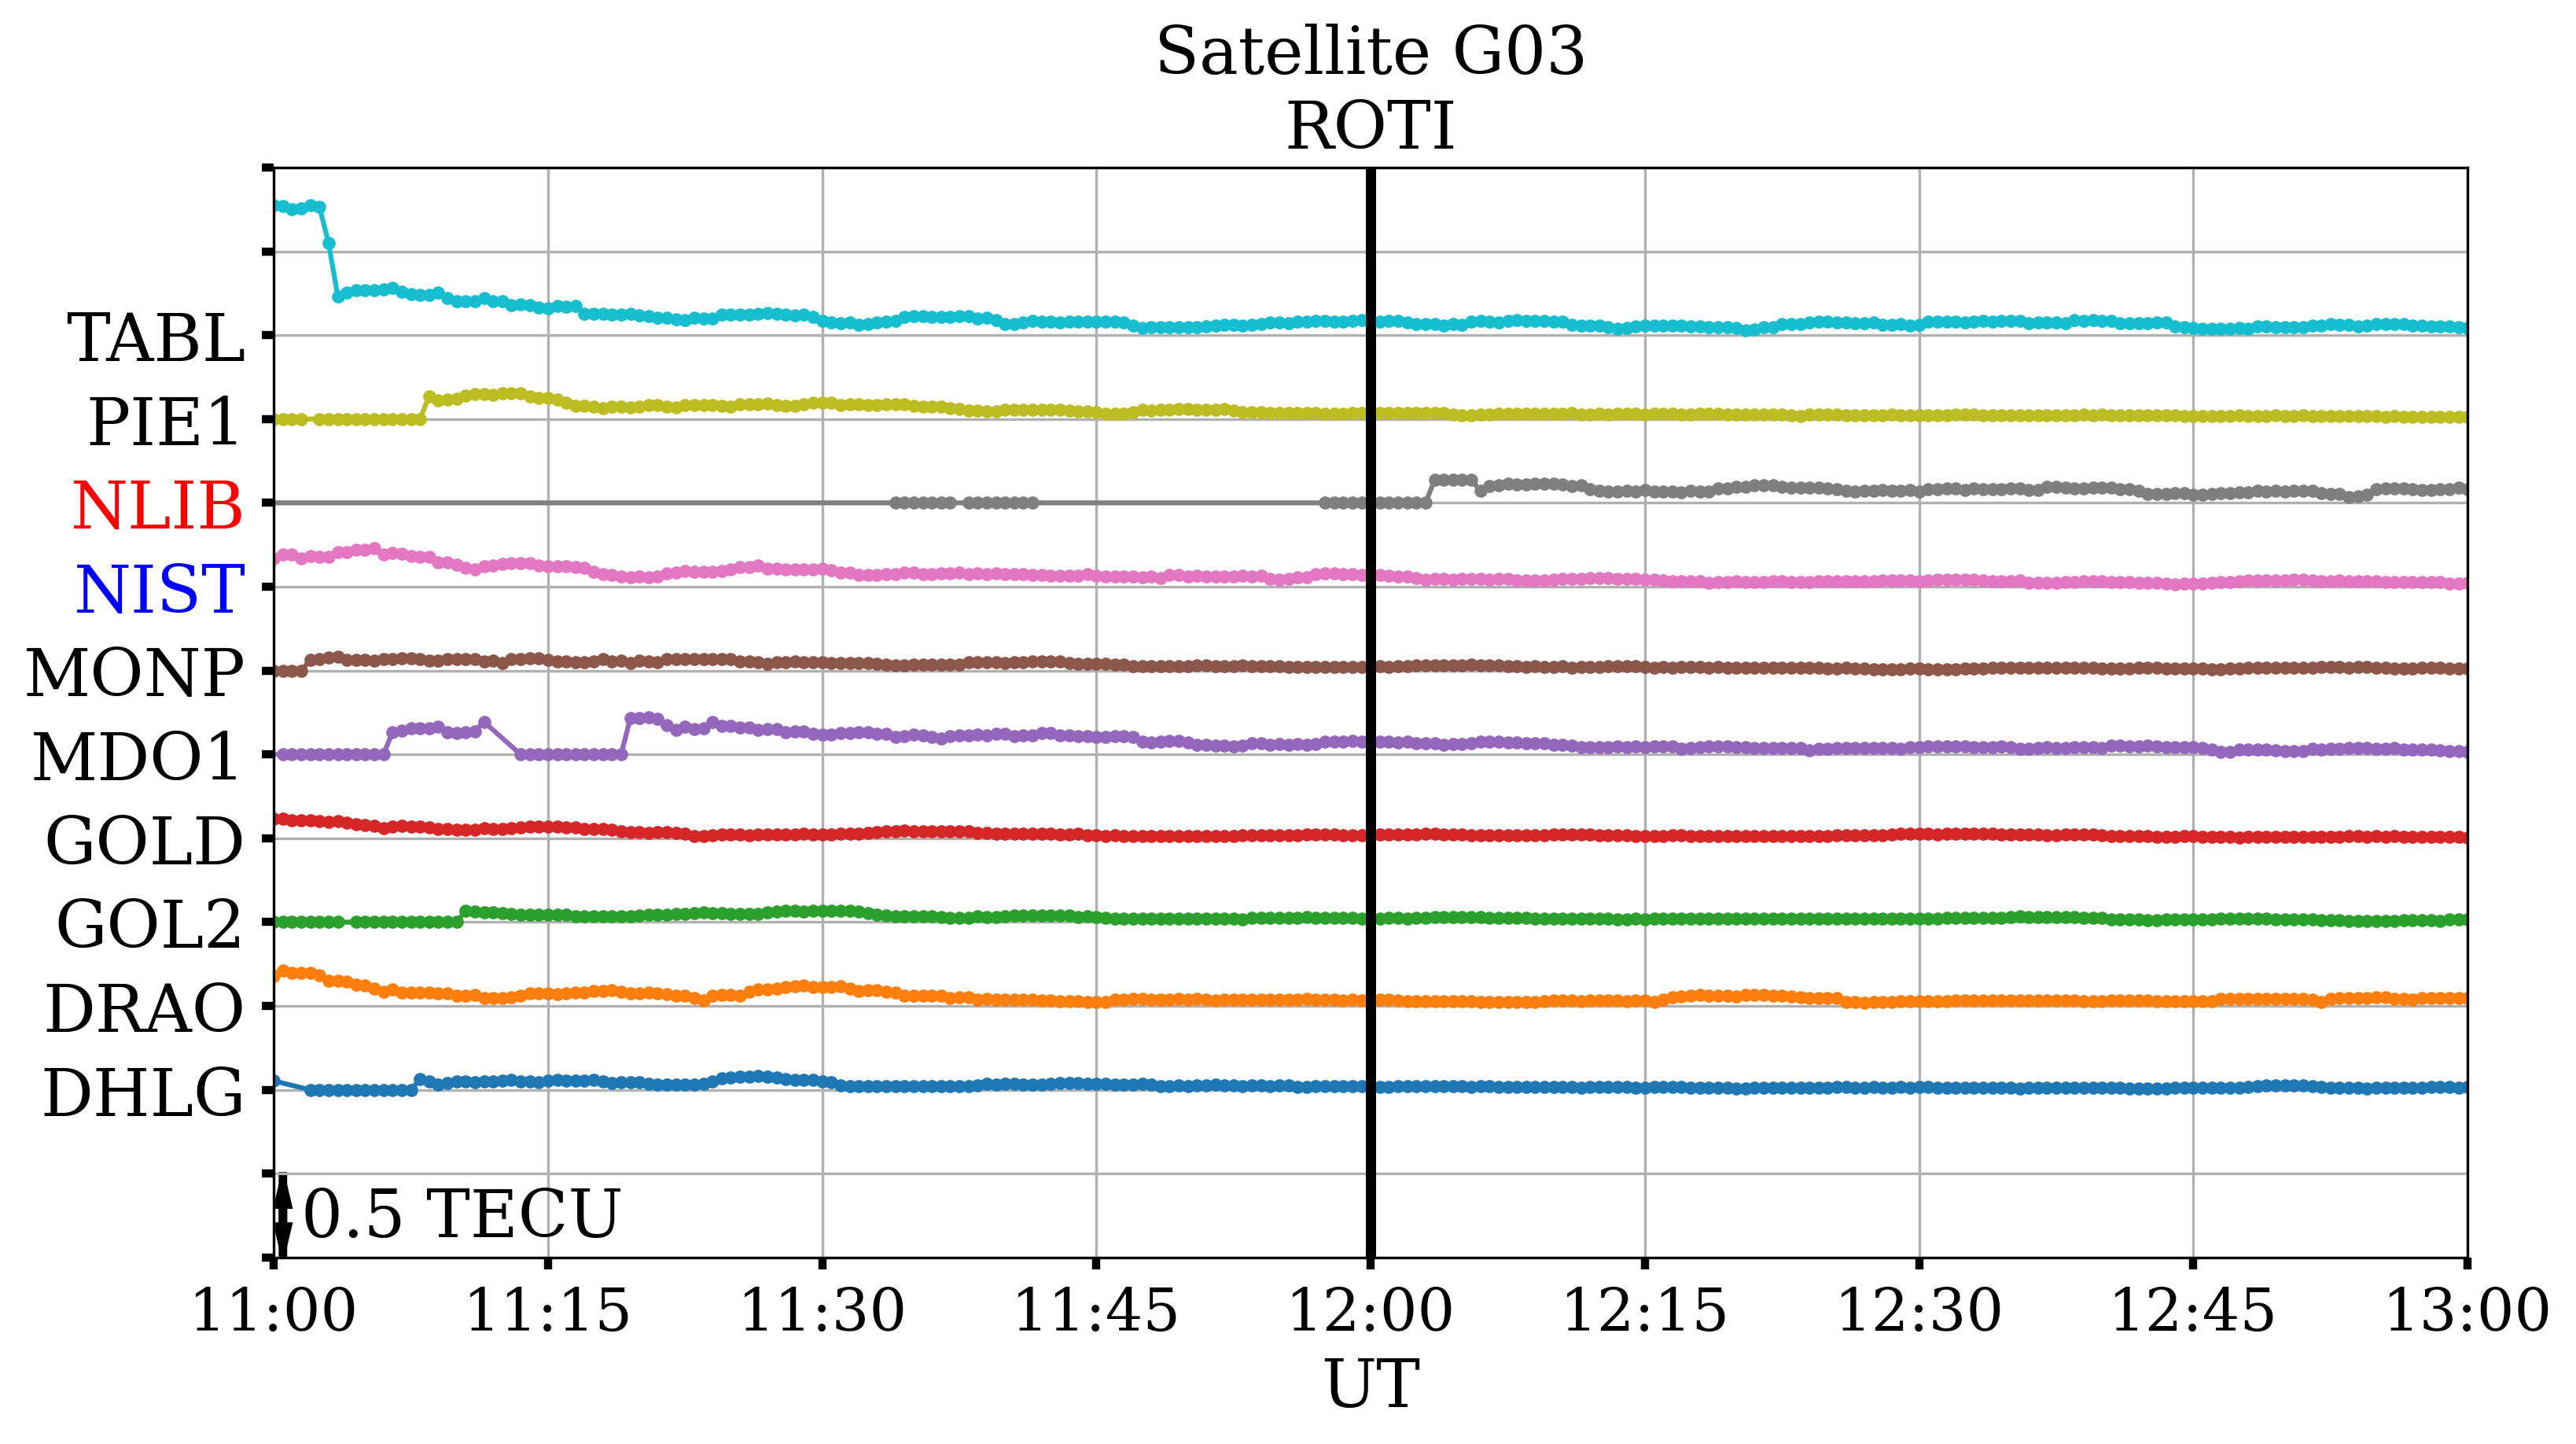

In [246]:
event = PointEvent(40, -100, datetime(2025, 1, 5, 12).replace(tzinfo=_UTC))
satillite = GnssSat("G03", "G")
colors = {'NLIB': "red", "NIST": "blue"}
plot_single_sat(
    data_plot=series_by_sat, 
    sat=satillite, 
    plot_product=DataProducts.roti, 
    event=event,
    figsize = (12, 6),
    site_labels=True,
    label_colors=colors
)

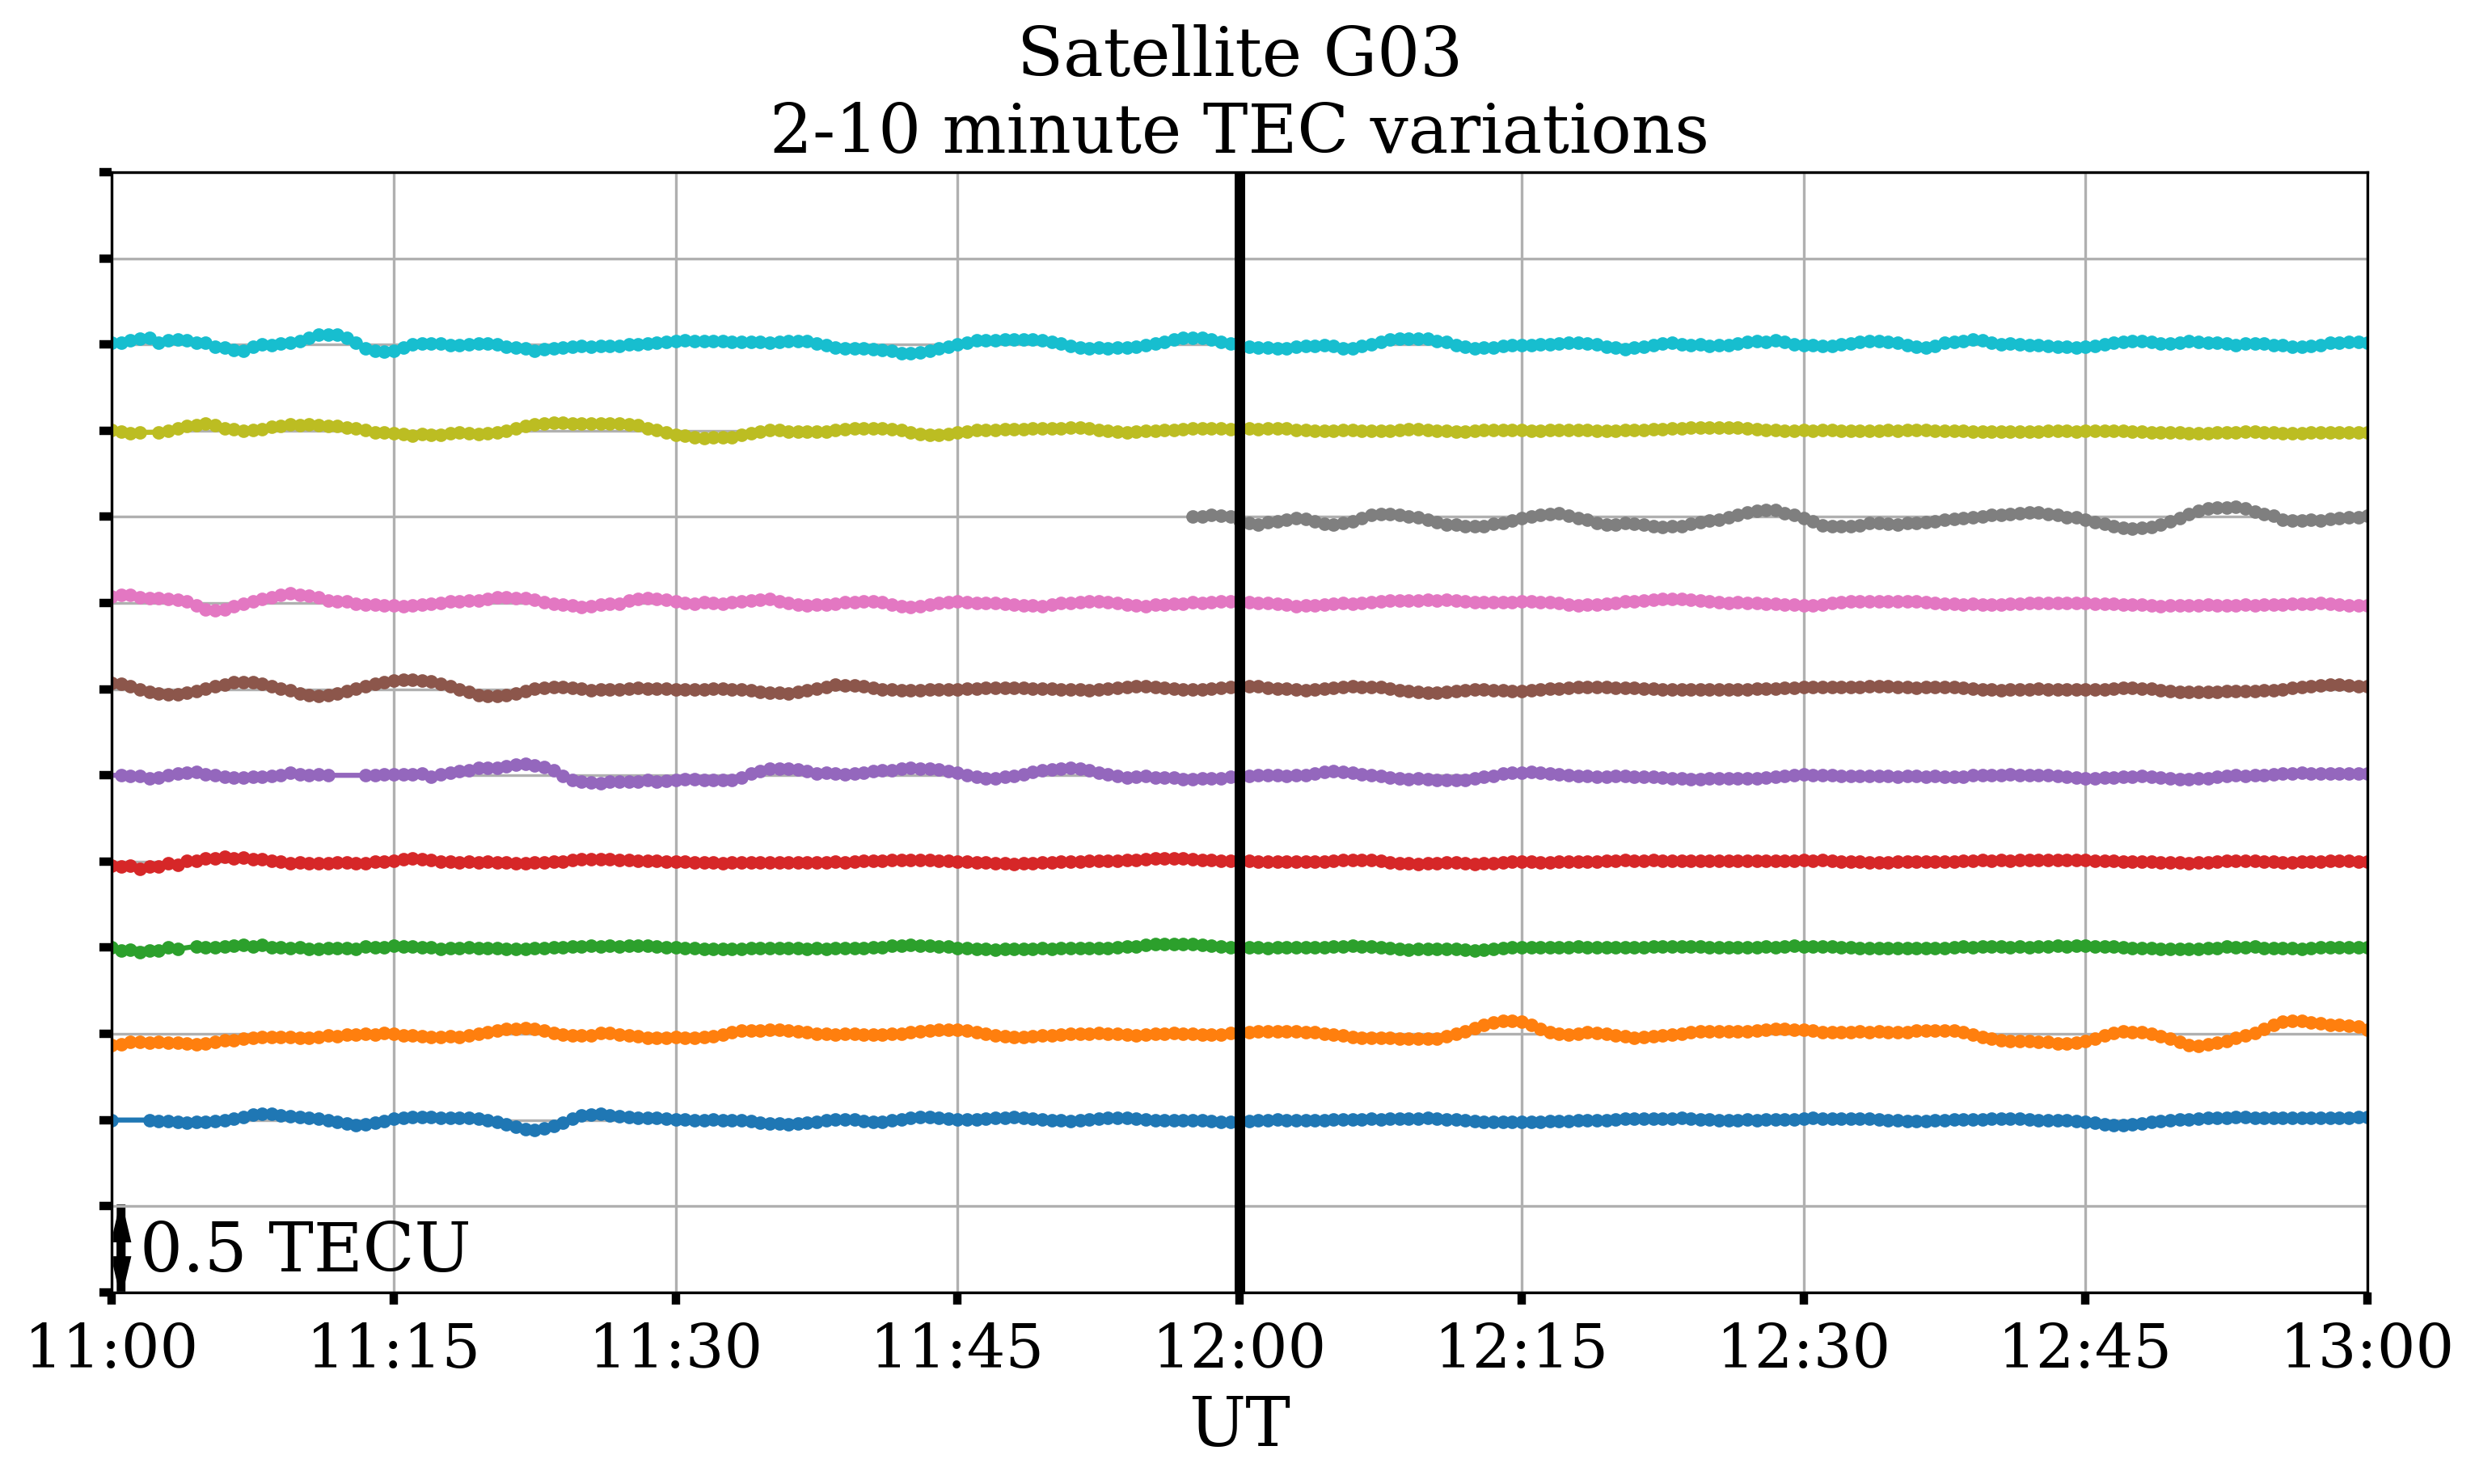

In [230]:
event = PointEvent(40, -100, datetime(2025, 1, 5, 12).replace(tzinfo=_UTC))
satillite = GnssSat("G03", "G")
plot_single_sat(
    data_plot=series_by_sat, 
    sat=satillite, 
    plot_product=DataProducts.dtec_2_10, 
    event=event,
    figsize = (12, 6)
)

# Have fun!